# An Introduction to SageMaker Random Cut Forests

***Unsupervised anomaly detection on timeseries data a Random Cut Forest algorithm.***

---

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Training](#Training)
1. [RealTimeInference](#Inference)
1. [Serverless Inference](#ServerlessInference)

## Introduction
***

Amazon SageMaker Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. Examples of when anomalies are important to detect include when website activity uncharactersitically spikes, when temperature data diverges from a periodic behavior, or when changes to public transit ridership reflect the occurrence of a special event.

In this notebook, we will use the SageMaker RCF algorithm to train an RCF model on the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset which records the amount New York City taxi ridership over the course of six months. We will then use this model to predict anomalous events by emitting an "anomaly score" for each data point. The main goals of this notebook are,

* to learn how to obtain, transform, and store data for use in Amazon SageMaker;
* to create an AWS SageMaker training job on a data set to produce an RCF model,
* use the RCF model to perform inference with an Amazon SageMaker endpoint.

Random cut forest is a tree based algorithm. It takes a bunch of random data points (Random), cuts them randomly and creates trees. It then looks at all of the trees together (Forest) to determine whether a particular data point is an anomaly. 

To create a tree, you randomly subdivide the data points until you isolate the point you’re testing to determine whether it’s an anomaly. Each time you subdivide the data points, it creates a new level of the tree. The fewer times you need to subdivide the data points before you isolate the target data point the more likely it is that the data point is an anomaly for that sample of data.

A good pictorial explanation is given in this [link](https://freecontent.manning.com/the-randomcutforest-algorithm)

## Setup

***

*This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.*

Our first step is to setup our AWS credentials so that AWS SageMaker can store and access training data and model artifacts. We also need some data to inspect and to train upon.

### Select Amazon S3 Bucket

We first need to specify the locations where the original data is stored and where we will store our training data and trained model artifacts. ***This is the only cell of this notebook that you will need to edit.*** In particular, we need the following data:

* `bucket` - An S3 bucket accessible by this account.
* `prefix` - The location in the bucket where this notebook's input and output data will be stored. (The default value is sufficient.)
* `downloaded_data_bucket` - An S3 bucket where data is downloaded from this [link](https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv) and stored.
* `downloaded_data_prefix` - The location in the bucket where the data is stored.

In [2]:
import boto3
import botocore
import sagemaker
import sys


bucket = (
    sagemaker.Session().default_bucket()
)  # Feel free to change to another bucket you have access to
prefix = "sagemaker/rcf-benchmarks"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = f"sagemaker-sample-files"
downloaded_data_prefix = "datasets/tabular/anomaly_benchmark_taxi"


def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(
        f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}"
    )

Training input/output will be stored in: s3://sagemaker-us-east-1-462768798410/sagemaker/rcf-benchmarks
Downloaded training data will be read from s3://sagemaker-sample-files/datasets/tabular/anomaly_benchmark_taxi


### Obtain and Inspect Example Data


Our data comes from the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset [[1](https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv)]. We downloaded data from [here](https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv) and stored in an S3 bucket. These data consists of the number of New York City taxi passengers over the course of six months aggregated into 30-minute buckets. We know, a priori, that there are anomalous events occurring during the NYC marathon, Thanksgiving, Christmas, New Year's day, and on the day of a snow storm.

> [1] https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv

In [3]:
%%time

import pandas as pd

data_filename = "NAB_nyc_taxi.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)
taxi_data = pd.read_csv(data_filename, delimiter=",")

CPU times: user 61.4 ms, sys: 12.1 ms, total: 73.5 ms
Wall time: 202 ms


Before training any models it is important to inspect our data, first. Perhaps there are some underlying patterns or structures that we could provide as "hints" to the model or maybe there is some noise that we could pre-process away. The raw data looks like this:

In [4]:
taxi_data.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Human beings are visual creatures so let's take a look at a plot of the data.

<AxesSubplot:>

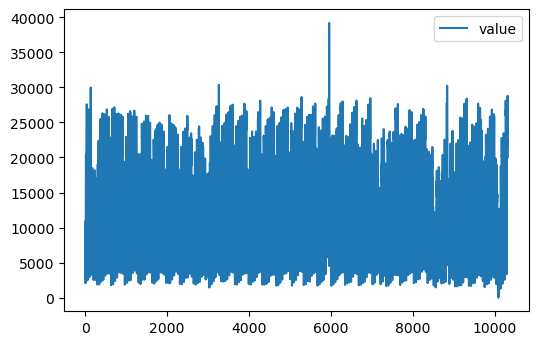

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 100

taxi_data.plot()

Human beings are also extraordinarily good at perceiving patterns. Note, for example, that something uncharacteristic occurs at around datapoint number 6000. Additionally, as we might expect with taxi ridership, the passenger count appears more or less periodic. Let's zoom in to not only examine this anomaly but also to get a better picture of what the "normal" data looks like.

<AxesSubplot:>

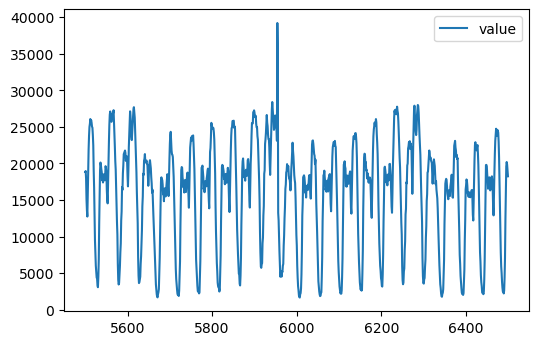

In [6]:
taxi_data[5500:6500].plot()

Here we see that the number of taxi trips taken is mostly periodic with one mode of length approximately 50 data points.

Here is the data across the day containing the above anomaly:

In [7]:
taxi_data[5952:6000]

,timestamp,value
5952,2014-11-02 00:00:00,25110
5953,2014-11-02 00:30:00,23109
5954,2014-11-02 01:00:00,39197
5955,2014-11-02 01:30:00,35212
5956,2014-11-02 02:00:00,13259
5957,2014-11-02 02:30:00,12250
5958,2014-11-02 03:00:00,10013
5959,2014-11-02 03:30:00,7898
5960,2014-11-02 04:00:00,6375
5961,2014-11-02 04:30:00,4532


## Training

***

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm on the taxi cab data.

### Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

In [8]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data.value.to_numpy().reshape(-1, 1)))

2022-11-03 06:55:30 Starting - Starting the training job...
2022-11-03 06:55:57 Starting - Preparing the instances for trainingProfilerReport-1667458530: InProgress
.........
2022-11-03 06:57:14 Downloading - Downloading input data...
2022-11-03 06:57:54 Training - Downloading the training image..............Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2022 07:00:12 INFO 139935867021120] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[11/03/2022 07:00:12 INFO 139935867021120] Merging with provided configuration from /opt/ml/input/config/hyperparameters.j

If you see the message

> `===== Job Complete =====`

at the bottom of the output logs then that means training successfully completed and the output RCF model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:

In [9]:
print(f"Training job name: {rcf.latest_training_job.job_name}")

Training job name: randomcutforest-2022-11-03-06-55-30-607


## Inference

***

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost.

In [10]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-----------!

Congratulations! You now have a functioning SageMaker RCF inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [11]:
print(f"Endpoint name: {rcf_inference.endpoint}")

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2022-11-03-07-00-45-820


### Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [12]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [22]:
taxi_data_numpy = taxi_data.value.to_numpy().reshape(-1, 1)
print(taxi_data_numpy[:6])
results = rcf_inference.predict(
    taxi_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

[[10844]
 [ 8127]
 [ 6210]
 [ 4656]
 [ 3820]
 [ 2873]]


### Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire taxi dataset.

In [23]:
results = rcf_inference.predict(taxi_data_numpy)
scores = [datum["score"] for datum in results["scores"]]

# add scores to taxi data frame and print first few values
taxi_data["score"] = pd.Series(scores, index=taxi_data.index)
taxi_data.head()

,timestamp,value,score
0,2014-07-01 00:00:00,10844,0.931037
1,2014-07-01 00:30:00,8127,1.057896
2,2014-07-01 01:00:00,6210,0.981963
3,2014-07-01 01:30:00,4656,0.910381
4,2014-07-01 02:00:00,3820,0.971730


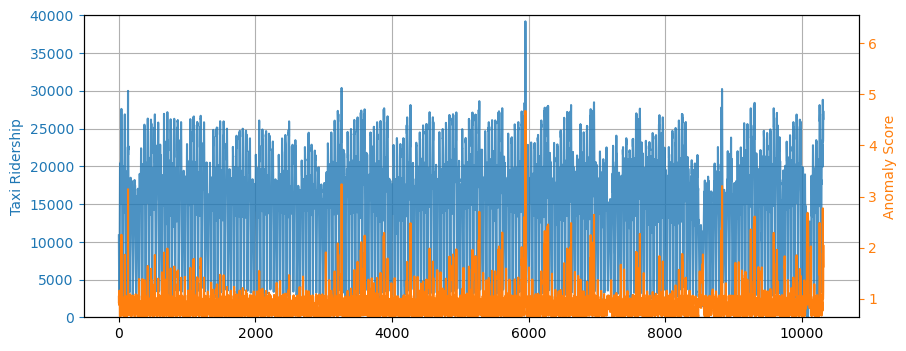

In [24]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
# start, end = 5500, 6500
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data_subset["value"], color="C0", alpha=0.8)
ax2.plot(taxi_data_subset["score"], color="C1")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Taxi Ridership", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below we print and plot any data points with scores greater than "X" standard deviations from the mean score.

In [29]:
score_mean = taxi_data["score"].mean()
score_std = taxi_data["score"].std()
score_cutoff = score_mean + 6 * score_std
print(score_cutoff)

anomalies = taxi_data_subset[taxi_data_subset["score"] > score_cutoff]
print(len(anomalies))
print(anomalies)

2.452721339944479
39
                 timestamp  value     score
134    2014-07-03 19:00:00  29985  3.143083
3261   2014-09-06 22:30:00  30313  3.223948
3262   2014-09-06 23:00:00  30373  3.240060
3263   2014-09-06 23:30:00  28464  2.639087
4271   2014-09-27 23:30:00  28113  2.479333
5279   2014-10-18 23:30:00  28626  2.702102
5280   2014-10-19 00:00:00  28093  2.474609
5942   2014-11-01 19:00:00  28398  2.605403
5954   2014-11-02 01:00:00  39197  4.676207
5955   2014-11-02 01:30:00  35212  4.171150
6623   2014-11-15 23:30:00  28114  2.480542
6958   2014-11-22 23:00:00  28126  2.488108
6959   2014-11-22 23:30:00  28472  2.642442
8833   2015-01-01 00:30:00  29547  3.020739
8834   2015-01-01 01:00:00  30236  3.204589
8835   2015-01-01 01:30:00  28348  2.581706
9302   2015-01-10 19:00:00  28043  2.455048
9310   2015-01-10 23:00:00  28301  2.561967
9311   2015-01-10 23:30:00  28401  2.607452
10078  2015-01-26 23:00:00    297  2.569262
10079  2015-01-26 23:30:00    189  2.606448
10080  2015

The following is a list of known anomalous events which occurred in New York City within this timeframe:

* `2014-11-02` - NYC Marathon
* `2015-01-01` - New Year's Eve
* `2015-01-27` - Snowstorm

Note that our algorithm managed to capture these events along with quite a few others. Below we add these anomalies to the score plot.

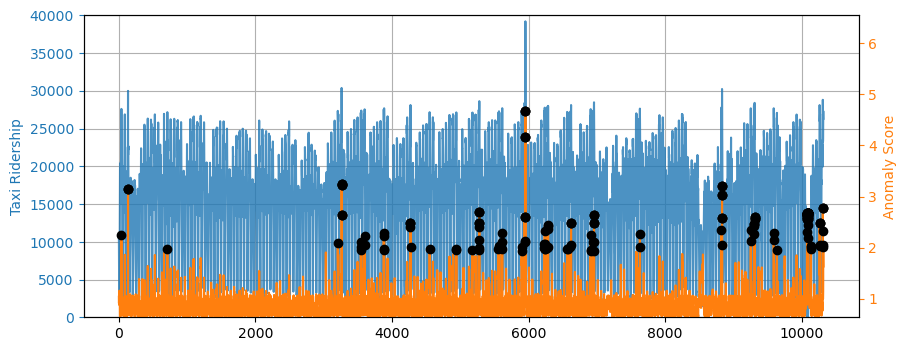

In [30]:
ax2.plot(anomalies.index, anomalies.score, "ko")
fig

With the current hyperparameter choices we see that the three-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the ridership plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

## ServerlessInference



Serverless Inference is ideal for workloads which have idle periods between traffic spurts and can tolerate cold starts. Serverless endpoints automatically launch compute resources and scale them in and out depending on traffic, eliminating the need to choose instance types or manage scaling policies. This takes away the undifferentiated heavy lifting of selecting and managing servers. Serverless Inference integrates with AWS Lambda to offer you high availability, built-in fault tolerance and automatic scaling.

With a pay-per-use model, Serverless Inference is a cost-effective option if you have an infrequent or unpredictable traffic pattern. During times when there are no requests, Serverless Inference scales your endpoint down to 0, helping you to minimize your costs.

### Endpoint Config Creation

This is where you can adjust the Serverless Configuration for your endpoint. You will define the max concurrent invocations for a single endpoint, known as **MaxConcurrency**, and the **Memory size**. 

Your serverless endpoint has a minimum RAM size of 1024 MB (1 GB), and the maximum RAM size you can choose is 6144 MB (6 GB). **The memory sizes you can choose are 1024 MB, 2048 MB, 3072 MB, 4096 MB, 5120 MB, or 6144 MB**. Serverless Inference auto-assigns compute resources proportional to the memory you select. If you choose a larger memory size, your container has access to more vCPUs. 

Serverless endpoints have a quota for how many concurrent invocations can be processed at the same time. If the endpoint is invoked before it finishes processing the first request, then it handles the second request concurrently. **You can set the maximum concurrency for a single endpoint up to 200, and the total number of serverless endpoints you can host in a Region is 50**. The maximum concurrency for an individual endpoint prevents that endpoint from taking up all of the invocations allowed for your account, and any endpoint invocations beyond the maximum are throttled.

If your endpoint does not receive traffic for a while and then your endpoint suddenly receives new requests, it can take some time for your endpoint to spin up the compute resources to process the requests. This is called a **cold start**. Since serverless endpoints provision compute resources on demand, your endpoint may experience cold starts. A cold start can also occur if your concurrent requests exceed the current concurrent request usage. The cold start time depends on your model size, how long it takes to download your model, and the start-up time of your container.

In [31]:
import boto3
from time import gmtime, strftime
client = boto3.client("sagemaker")
runtime = boto3.client("sagemaker-runtime")

In [32]:
print(rcf.model_data)

s3://sagemaker-us-east-1-462768798410/sagemaker/rcf-benchmarks/output/randomcutforest-2022-11-03-06-55-30-607/output/model.tar.gz


In [33]:
model_name='randomcutforest-2022-11-03-07-00-45-820'
rcf_serverless_config = 'rcf-serverless-epc'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())

In [35]:
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=rcf_serverless_config,
    ProductionVariants=[
        {
            "VariantName": "RCF-serverless",
            "ModelName": model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:us-east-1:462768798410:endpoint-config/rcf-serverless-epc2022-11-03-07-18-33


### Serverless Endpoint Creation

In [36]:
endpoint_name = "rcf-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=rcf_serverless_config,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:462768798410:endpoint/rcf-serverless-ep2022-11-03-07-19-24


In [38]:
# if content type for inference is text/csv, the value for the Body argument to invoke_endpoint should be a string with comma separated
import io
from io import StringIO
csv_file = io.StringIO()
taxi_data["value"].to_csv(csv_file, sep=",", header=False, index=False)
inf_payload_as_csv = csv_file.getvalue()

In [39]:
%%time
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=inf_payload_as_csv,
    ContentType="text/csv",
)

CPU times: user 12.5 ms, sys: 0 ns, total: 12.5 ms
Wall time: 322 ms


In [40]:
import json
inference_result=response["Body"].read()
results_new=json.loads(inference_result)
scores = [datum["score"] for datum in results_new["scores"]]

In [42]:
# add scores to data frame and print first few values
taxi_data["serverless_inf_score"] = pd.Series(scores, index=taxi_data.index)
taxi_data[0:10]

,timestamp,value,score,serverless_inf_score
0,2014-07-01 00:00:00,10844,0.931037,0.931037
1,2014-07-01 00:30:00,8127,1.057896,1.057896
2,2014-07-01 01:00:00,6210,0.981963,0.981963
3,2014-07-01 01:30:00,4656,0.910381,0.910381
4,2014-07-01 02:00:00,3820,0.971730,0.971730
5,2014-07-01 02:30:00,2873,0.928999,0.928999
6,2014-07-01 03:00:00,2369,0.950528,0.950528
7,2014-07-01 03:30:00,2064,1.158320,1.158320
8,2014-07-01 04:00:00,2221,1.082995,1.082995
9,2014-07-01 04:30:00,2158,1.123834,1.123834


In [46]:
%%time

# inferencing on single datapoint

response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=b"2000",
    ContentType="text/csv",
)

CPU times: user 9.08 ms, sys: 3.51 ms, total: 12.6 ms
Wall time: 129 ms


In [47]:
import json
inference_result=response["Body"].read()
results_new=json.loads(inference_result)
scores = [datum["score"] for datum in results_new["scores"]]
print(scores)

[1.2321525642]


### Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [ ]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)